DATA201 project

Author: Josh Smith

This overall goal of this group project was to scrape data from various sources around the web and wrangle the resulting data into a usable dataframe, which can be joined to other tables and/or subsequently analysed.

For my section of the project, I scraped daily COVID-19 case data from the WHO website, as well as annual health expenditure around the world from the UN data repository. The goal of this was to determine if there was any correlation between a countries response to COVID-19 and the funding level of their health system. 

Data sources:
*   https://covid19.who.int/table
*   https://data.un.org/

Load builtin libraries

In [ ]:
library(tidyverse)
library(magrittr)
library(purrr)
library(glue)
library(stringr)
library(rvest)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract



Attaching package: ‘glue’


The following object is masked from ‘package:dplyr’:

    collapse


Loading required package: xml2


Attaching package: ‘rvest’


The following object is masked from ‘package:purrr’:

    pluck


The following object is masked from ‘package:readr’:

    guess_encoding




Install external libraries

In [ ]:
install.packages("tidytext")
remotes::install_github("dmi3kno/polite")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘SnowballC’, ‘hunspell’, ‘tokenizers’, ‘janeaustenr’





backports    (1.1.10 -> 1.2.0 ) [CRAN]
R6           (2.4.1  -> 2.5.0 ) [CRAN]
parallelly   (NA     -> 1.21.0) [CRAN]
listenv      (NA     -> 0.8.0 ) [CRAN]
globals      (NA     -> 0.13.1) [CRAN]
future       (NA     -> 1.20.1) [CRAN]
future.apply (NA     -> 1.6.0 ) [CRAN]
spiderbar    (NA     -> 0.2.3 ) [CRAN]
robotstxt    (NA     -> 0.7.13) [CRAN]
ratelimitr   (NA     -> 0.4.1 ) [CRAN]


Installing 10 packages: backports, R6, parallelly, listenv, globals, future, future.apply, spiderbar, robotstxt, ratelimitr

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



✔  checking for file ‘/tmp/Rtmp1K39On/remotes3b22357fa3/dmi3kno-polite-15655f1/DESCRIPTION’
─  preparing ‘polite’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘polite_0.1.1.9020.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Load external libraries

In [ ]:
library(tidytext)
library(polite)

In [ ]:
#This is the dataset for the COVID data from the WHO. 
#It is the daily case data that is reported by governments to the WHO. 
WHOcovid_url_title <- "https://covid19.who.int/table"
WHOcovid_url_page <- read_html(WHOcovid_url_title)

In [ ]:
#This is the UN data repository which contains several datasets focused around
#population and other socio-economic factors around the world
UN_data_title <- "https://data.un.org/"
UN_data_page <- read_html(UN_data_title)

In [ ]:
#Scrape all .csv links in the WHO page
WHOcovid_href_links <- WHOcovid_url_page %>%
  html_nodes(".sc-AxjAm > a") %>%
  html_attrs() %>%
  map_chr("href")

In [ ]:
#Glue correct .csv link suffix to the WHO domain
WHOcovid_url <- glue("https://covid19.who.int{WHOcovid_href_links[13]}")

In [ ]:
#Read the dataset from the WHO link and pipe into a local dataframe
#Limit cumulative case results to be from a recent date
covid_df = read_csv(WHOcovid_url) %>%
  rename(date = Date_reported) %>%
  filter(date == '2020-10-06') %>%
  select(Country, Cumulative_cases)


── Column specification ────────────────────────────────────────────────────────
cols(
  Date_reported = col_date(format = ""),
  Country_code = col_character(),
  Country = col_character(),
  WHO_region = col_character(),
  New_cases = col_double(),
  Cumulative_cases = col_double(),
  New_deaths = col_double(),
  Cumulative_deaths = col_double()
)




In [ ]:
#Scrape all links to .csv files from the UN data repository into a dataframe
UN_data_href <- UN_data_page %>%
  html_nodes(".NoBullets > a") %>%
  html_attrs() %>%
  map_chr("href")

In [ ]:
#Convert dataframe to list format and convert health data URL string to suitable URL
#format by stripping all whitespace characters
UN_data_href %<>% as.list()
UN_link_suffix <- UN_data_href[44] %>%
  str_replace_all(" ", "%20")

In [ ]:
#Glue the specified health data URL suffix to the UN domain
health_url <- glue("https://data.un.org/{UN_link_suffix}")
#Convert the population data URL string to a suitable URL format 
Population_link_suffix <- UN_data_href[2] %>%
  str_replace_all(" ", "%20")
#Glue URL suffix to UN domain
Population_url <- glue("https://data.un.org/{Population_link_suffix}")

In [ ]:
#Read the population data csv file into a dataframe.
#Rename columns with wrongly parsed column names.
#Filter data so that there is only the most recent population numbers for each country.
#Convert each population row to a numeric value
#Convert each population row from being in Millions of people to the actual number. 
population_df <- read_csv(Population_url) %>%
 rename(Country = "Population, density and surface area") %>%
 rename(Year = X3) %>%
 rename(Series = X4) %>%
 rename(Population = X5) %>%
 filter(Year == "2019") %>%
 filter(Series == "Population mid-year estimates (millions)") %>%
 select(Country, Population) %>%
 mutate(Population = as.numeric(Population)) %>%
 mutate(Population = Population * 1000000)

Warning message:
“Missing column names filled in: 'X3' [3], 'X4' [4], 'X5' [5], 'X6' [6], 'X7' [7]”

── Column specification ────────────────────────────────────────────────────────
cols(
  T02 = col_character(),
  `Population, density and surface area` = col_character(),
  X3 = col_character(),
  X4 = col_character(),
  X5 = col_character(),
  X6 = col_character(),
  X7 = col_character()
)




In [ ]:
#Join the population dataframe with the covid number dataframe, using the country name as a key
#Mutate the dataframe to give the covid case numbers as a percentage of the total population size
#instead of the raw numbers, this gives a proportional result of this data and allows
#better comparisons between countries. 
covid_df_pct <- inner_join(
  covid_df, population_df, by="Country"
) %>% mutate(Cases_Percent_Pop = Cumulative_cases / Population * 100) %>%
  select(-Population)

In [ ]:
#Read the health expenditure data into a dataframe from the csv file
#Rename columns with incorrectly parsed column names
#Filter for the most recent result in the dataframe
#Can filter between 2 different columns of data, depending on the interest of 
#whomever is analysing it
#Convert health data column to a numeric format   
health_df <- read_csv(health_url) %>%
  rename(Year = X3) %>%
  rename(Country = "Expenditure on health") %>%
  rename(Category = X4) %>%
  rename(Health_Spend_Percent_GDP = X5) %>%
  filter(Year == 2017) %>%
  # filter(Category == "Current health expenditure (% of GDP)") %>%
  filter(Category == "Domestic general government health expenditure (% of total government expenditure)") %>%
  mutate(Health_Spend_Percent_GDP = as.numeric(Health_Spend_Percent_GDP)) %>%
  select(Country,Health_Spend_Percent_GDP)

Warning message:
“Missing column names filled in: 'X3' [3], 'X4' [4], 'X5' [5], 'X6' [6], 'X7' [7]”

── Column specification ────────────────────────────────────────────────────────
cols(
  T11 = col_character(),
  `Expenditure on health` = col_character(),
  X3 = col_character(),
  X4 = col_character(),
  X5 = col_character(),
  X6 = col_character(),
  X7 = col_character()
)




In [ ]:
#Join the covid dataframe on the health expenditure dataframe, using the country as a key
#Omit any resulting na values
covid_health_spend_tables <- right_join(
  covid_df_pct, health_df, by="Country"
  ) %>% na.omit()
covid_health_spend_tables

Country,Cumulative_cases,Cases_Percent_Pop,Health_Spend_Percent_GDP
<chr>,<dbl>,<dbl>,<dbl>
Afghanistan,39572,0.104022417,2.3191
Albania,14410,0.500190913,14.6789
Algeria,52270,0.121408215,10.7341
Andorra,2370,3.073929961,14.0176
Angola,5530,0.017376113,5.4284
Antigua and Barbuda,107,0.110195675,9.4786
Argentina,798486,1.783102989,16.0513
Armenia,53083,1.794739155,5.2735
Australia,27149,0.107720448,17.7973


In [ ]:
# Uncomment any of the following lines to sort the table by various variables
ordered_df <- covid_health_spend_tables[with(covid_health_spend_tables, order(-Cases_Percent_Pop)), ]
# ordered_df <- covid_health_spend_tables[with(covid_health_spend_tables, order(-Health_Spend_Percent_GDP)), ]
ordered_df

Country,Cumulative_cases,Cases_Percent_Pop,Health_Spend_Percent_GDP
<chr>,<dbl>,<dbl>,<dbl>
Qatar,126692,4.4734296,6.2930
Bahrain,73116,4.4550329,8.4938
Israel,267848,3.1439773,11.9277
Andorra,2370,3.0739300,14.0176
Panama,115286,2.7149115,20.0809
Kuwait,107592,2.5573911,8.9203
Peru,828169,2.5473893,14.8979
Chile,471746,2.4891621,17.7318
Brazil,4915289,2.3289745,10.2553


In [ ]:
options(repr.plot.width=15, repr.plot.height=8)

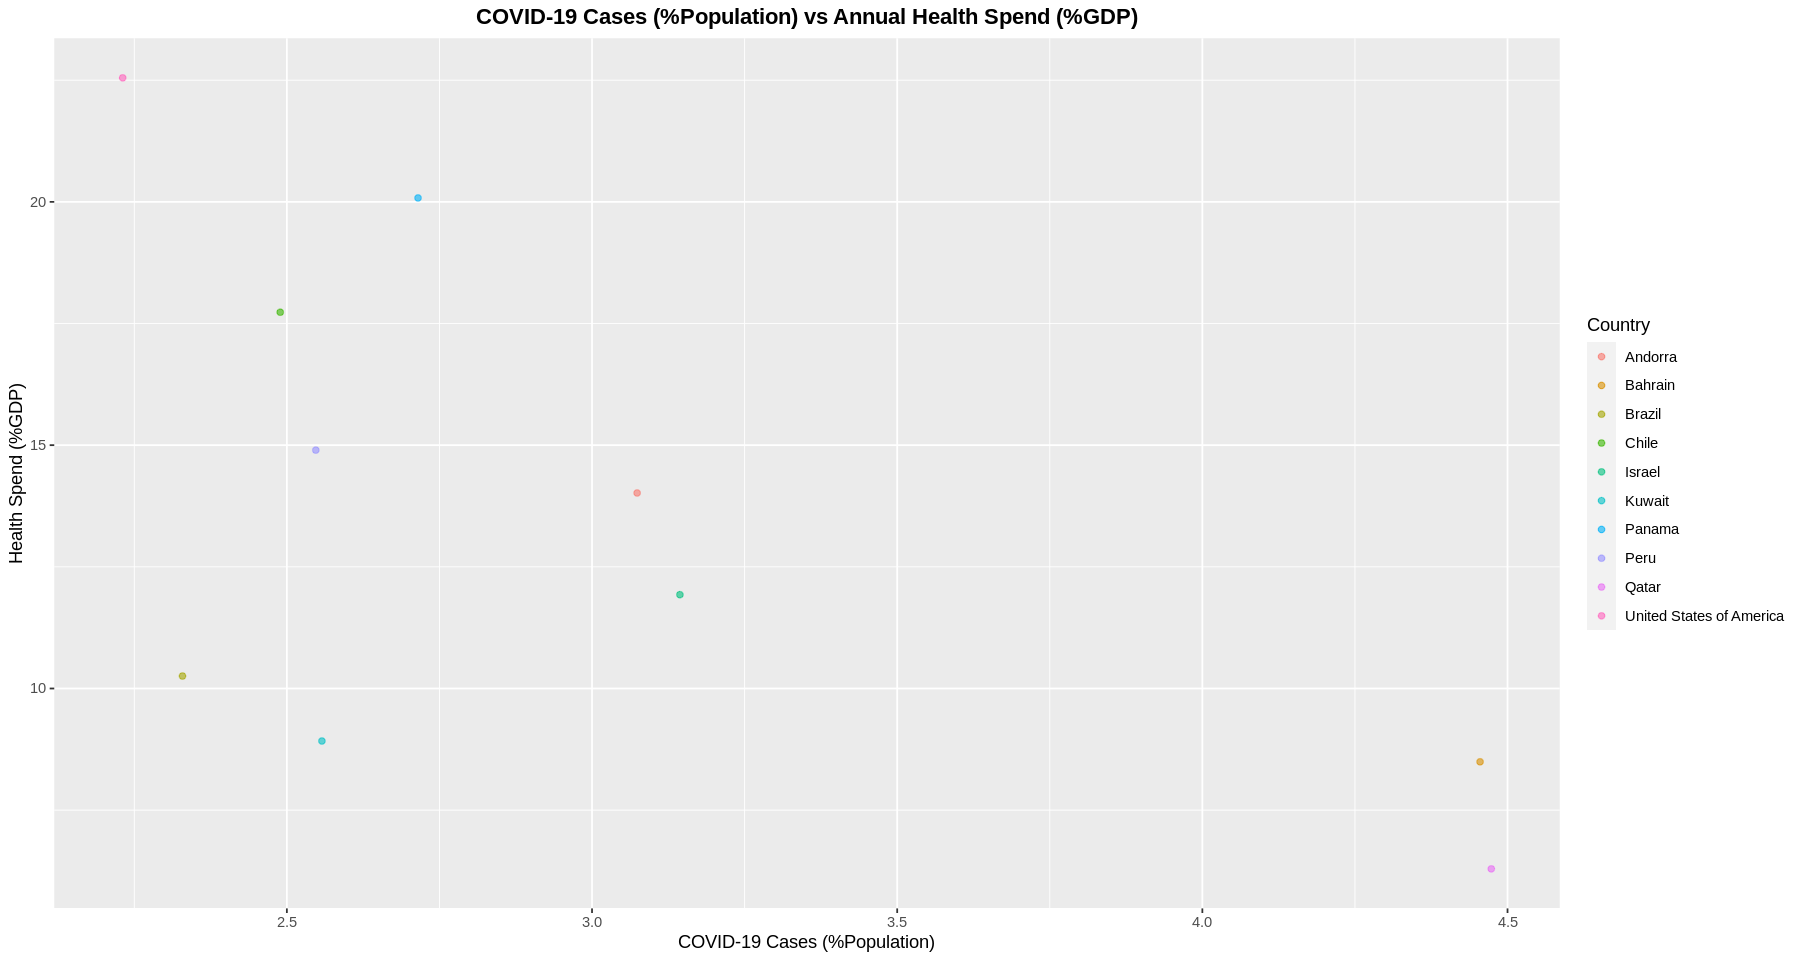

In [ ]:
covid_plot <- ordered_df %>%
  top_n(10, Cases_Percent_Pop) %>%
  ggplot(
    aes(
      x = Cases_Percent_Pop, y = Health_Spend_Percent_GDP, colour=Country)) +
      geom_point(alpha = 0.6) +
      labs(
        title = "COVID-19 Cases (%Population) vs Annual Health Spend (%GDP)", 
      y = "Health Spend (%GDP)", 
      x = "COVID-19 Cases (%Population)",
      colour = "Country") +
      theme(
        plot.title = element_text(face = "bold", hjust = 0.5)
      )


 covid_plot 